# Deep Learning on Ancient DNA

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
Modern contamination is a big issue in Ancient DNA research area. Up to now the most reliable way to address how ancient is an NGS sample is to use deamination pattern inference which is based on averaging thousands and millions of aligned reads. Here we present a Convolutional Neural Network (CNN) based classifier which gives a per-read prediction of how ancient a read is. We also address which exactly patterns are responsible for such classification.

### Table of Contents:
* [Deep Learning in Genomics](#Deep Learning in Genomics)
* [Extract Reads from Neanderthals](#Extract Reads from Neanderthals)
* [Extract Reads from Modern Humans](#Extract Reads from Modern Humans)
* [Prepare Data for Convolutional Neural Network](#Prepare Data for Convolutional Neural Network)
* [Run Shallow Convolutional Neural Network](#Run Shallow Convolutional Neural Network)
* [Interpret Results of Convolutional Neural Network](#Interpret Results of Convolutional Neural Network)
* [Predict Ancient Status](#Predict Ancient Status)
* [Run Deep Convolutional Neural Network](#Run Deep Convolutional Neural Network)

### Deep Learning in Genomics <a class="anchor" id="Deep Learning in Genomics"></a>

Convolutional Neural Networks (CNNs) demonstrate state-of-the-art predictions of functional motifs in genomics. CNNs are use-ful in settings in which some spatially invariant patterns in the input are expected, such as images or sequential data. The input into a CNN is typically a matrix of real values. In genomics, the input might be a DNA sequence, in which the nucleotides A, C, T and G are encoded as [1,0,0,0], [0,1,0,0], [0,0,1,0] and [0,0,0,1]. Neurons that directly read in the data input are called the first, or input, layer. Layer two consists of neurons that read in the outputs of layer one, and so on for deeper layers, which are also referred to as hidden layers. The output of the neural network is the prediction of interest, e.g., whether the input DNA is an enhancer.

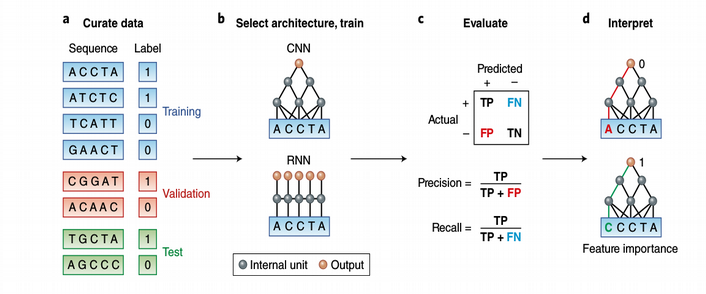

In [1]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/AncientDNA/CNN_Genomics.png')

### Extract Reads from Neanderthals <a class="anchor" id="Extract Reads from Neanderthals"></a>

We will start with extracting reads from the draft Neanderthal genome. We will use pysam Python module in order to read and parse the BAM-alignments for the draft Neanderthal genome:

In [2]:
import os
import pysam
import numpy as np
os.chdir('/home/nikolay/WABI/Misc/AncientDNA/')
neand = pysam.AlignmentFile("Neandertal.bam", "rb")

Let us display a few lines of the BAM-alignments for the draft Neanderthal genome:

In [3]:
iter = neand.fetch("chr1", 1, 50)
for x in iter:
    print(str(x))

M_SL-XAL_0003_30R1LAAXX:1:43:634:1649	16	0	38	84	97M	-1	-1	97	GCCCTAGCCCTAGCCTTAGCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCTAACCCTAAC	array('B', [25, 27, 24, 7, 16, 11, 24, 24, 23, 24, 19, 29, 27, 10, 29, 22, 24, 30, 28, 24, 17, 12, 10, 29, 40, 40, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 38, 40, 40, 40, 40, 40, 40, 40, 36, 40, 40, 40, 40, 40, 39, 40, 40, 37, 40, 40, 40, 37, 40, 40, 23, 26, 25, 18, 21, 28, 25, 23, 19, 20, 18, 25, 28, 29, 24, 20, 18, 24, 26, 24, 23, 22, 17, 26])	[('AS', 116)]
M_SL-XAL_0003_30R1LAAXX:2:30:429:1152	16	0	43	2	65M2I26M1I41M	-1	-1	135	AACCCTAACCCTAACCCTAACACGAACCATAAACCTAACCCTAACACGAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCCTCACCCTAACCCCTAACCCTAACCCTAACCCAGAGAGA	array('B', [34, 33, 28, 9, 25, 16, 29, 32, 32, 25, 26, 28, 30, 12, 31, 30, 31, 29, 30, 35, 19, 10, 20, 25, 28, 30, 23, 25, 28, 26, 29, 30, 26, 25, 27, 24, 30, 26, 28, 22, 29, 18, 26, 29, 27, 24, 26, 26, 24, 29, 21, 24,

We can easily extract read length information and plot read length distibution:

In [4]:
iter = neand.fetch("chr1", 0, 249000000)
neand_lengths = []
for i in iter:
    neand_lengths.append(i.infer_query_length())
print(neand_lengths[0:100])

[97, 135, 65, 59, 53, 109, 65, 49, 47, 47, 57, 85, 82, 59, 64, 46, 40, 40, 37, 67, 42, 56, 63, 30, 53, 35, 44, 47, 34, 50, 43, 42, 45, 69, 62, 63, 48, 68, 62, 83, 87, 48, 41, 42, 63, 58, 33, 42, 38, 37, 37, 52, 62, 66, 61, 74, 60, 46, 71, 52, 41, 74, 74, 39, 57, 38, 113, 59, 54, 53, 62, 47, 46, 36, 73, 71, 89, 78, 44, 71, 85, 36, 48, 42, 48, 57, 49, 53, 49, 42, 40, 40, 40, 62, 48, 68, 58, 58, 83, 57]


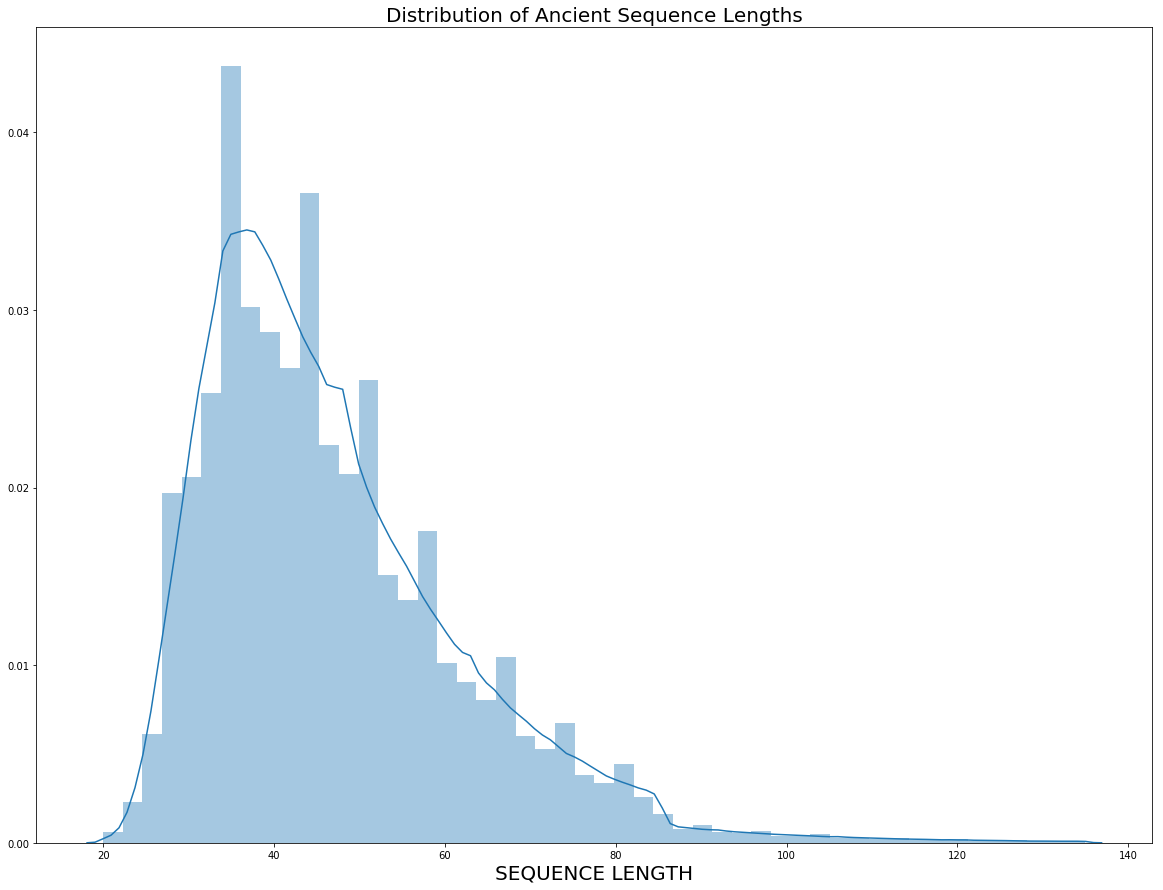

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
sns.distplot(neand_lengths)
plt.xlabel('SEQUENCE LENGTH', fontsize = 20)
plt.title('Distribution of Ancient Sequence Lengths', fontsize = 20)
plt.show()

Now we will extract read sequences with a certain read length, for example 76:

In [6]:
len(neand_lengths)

7539448

In [7]:
neand_seqs = []
for j in range(1,2):
    iter = neand.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                neand_seqs.append(i.get_forward_sequence())
len(neand_seqs)

34956

In [8]:
neand_seqs[0:10]

['AAATCATCAGTGGAAATTTAAAAAAATACACATGGCCAGGCCCCAGCCCAAATCACTAATAAGAATCTCCAAAACT',
 'ATGTGAAGCCCAACATTTAGGTTTTAAAAATCAAGCGTATAAATACAGAAGGTGGAGGGAACTTGCTTTAGACACA',
 'TCTTAAAGGGGGGTGGGAACTAAGCAGATCACAAGGGAGCTGCCCACAGAGGTCAAGACAAGGTCAGGTAGGCCGA',
 'TTTGTCTTTTAATCTGGCAACCCTAAAAGGCAAGGGCCAAAAATACCGGAGGCAAGCCAACGGATTCCAGGAGGGA',
 'ACAGATGCAGCCAGACAGAAAATAGTTTATCTTGCTGAGGTTTCTAATGTATTTGAAAGAGGCCTGGGTCTAGAAA',
 'GTCTAGAAGTCTACCCAGAGGGTTCTGTGTTGTGCACGCAAAGATAAGAACCTTCCCTGTAGGAGTTCCAGAGCCA',
 'TGGGTTGTTCTCTGAGAGGCAGGAGAGCATAGTGGTTACTAGGAAGGGAAGGACTTTGGGACTAGACTGCCTCGGC',
 'TTACTAGGAAGGGAAGGACTTTGGGACTAGACTGCCTCGGCTGAAGTCCTCTTTCTGCTTCATAGCCACGTGATCC',
 'TTCTCACCACAAAGACAGATTCAGTTATTACATATTGACAGAGTGAAAACTGAGGCACAGGTAACATGCCTAGAAT',
 'ATATGAAGCAGCAGGAGTGTTTTAATTAAAAGAAGGCAGTTGCTGTAACCAACTATAAACAAATAAAGGCTTAAAC']

We are going to implement a Convolutional Neural Network (CNN) which is typically used for image classification, in our case it will be a 1D "image". When working with images, data augmentation is known to dramatically improve performance of CNNs and make learning process more robust. For the case of genomics, data augmentation can be seen as an addition of reverse-complement sequences to the training data set. Let us use BioPython to create a reverse-complement sequence for each of the selected reads and add it to the data set.

In [9]:
from Bio.Seq import Seq
neand_reverse_complement_seqs = [str(Seq(i).reverse_complement()) for i in neand_seqs]
neand_reverse_complement_seqs[0:10]

['AGTTTTGGAGATTCTTATTAGTGATTTGGGCTGGGGCCTGGCCATGTGTATTTTTTTAAATTTCCACTGATGATTT',
 'TGTGTCTAAAGCAAGTTCCCTCCACCTTCTGTATTTATACGCTTGATTTTTAAAACCTAAATGTTGGGCTTCACAT',
 'TCGGCCTACCTGACCTTGTCTTGACCTCTGTGGGCAGCTCCCTTGTGATCTGCTTAGTTCCCACCCCCCTTTAAGA',
 'TCCCTCCTGGAATCCGTTGGCTTGCCTCCGGTATTTTTGGCCCTTGCCTTTTAGGGTTGCCAGATTAAAAGACAAA',
 'TTTCTAGACCCAGGCCTCTTTCAAATACATTAGAAACCTCAGCAAGATAAACTATTTTCTGTCTGGCTGCATCTGT',
 'TGGCTCTGGAACTCCTACAGGGAAGGTTCTTATCTTTGCGTGCACAACACAGAACCCTCTGGGTAGACTTCTAGAC',
 'GCCGAGGCAGTCTAGTCCCAAAGTCCTTCCCTTCCTAGTAACCACTATGCTCTCCTGCCTCTCAGAGAACAACCCA',
 'GGATCACGTGGCTATGAAGCAGAAAGAGGACTTCAGCCGAGGCAGTCTAGTCCCAAAGTCCTTCCCTTCCTAGTAA',
 'ATTCTAGGCATGTTACCTGTGCCTCAGTTTTCACTCTGTCAATATGTAATAACTGAATCTGTCTTTGTGGTGAGAA',
 'GTTTAAGCCTTTATTTGTTTATAGTTGGTTACAGCAACTGCCTTCTTTTAATTAAAACACTCCTGCTGCTTCATAT']

In [10]:
len(neand_reverse_complement_seqs)

34956

In [11]:
neand_seqs_augmented = neand_seqs + neand_reverse_complement_seqs
len(neand_seqs_augmented)

69912

In [12]:
characters = [list(i) for i in neand_seqs_augmented]
set(np.ndarray.flatten(np.array(characters)))

{'A', 'C', 'G', 'T'}

Thus we got tens of thousands of ancient reads of certain length from just chromosome 1, later we can loop over all chromosomes and all read lengths.

### Extract Reads from Modern Humans <a class="anchor" id="Extract Reads from Modern Humans"></a>

Now we perform the same operation with the reads from Modern Humans (French). We first extract read lenth information and plot the read length distribution:

In [13]:
modern = pysam.AlignmentFile("/home/nikolay/WABI/Misc/AncientDNA/French.bam", "rb")
iter = modern.fetch("chr1", 0, 1000000)
modern_lengths = []
for i in iter:
    modern_lengths.append(i.infer_query_length())
print(modern_lengths[0:100])

[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]


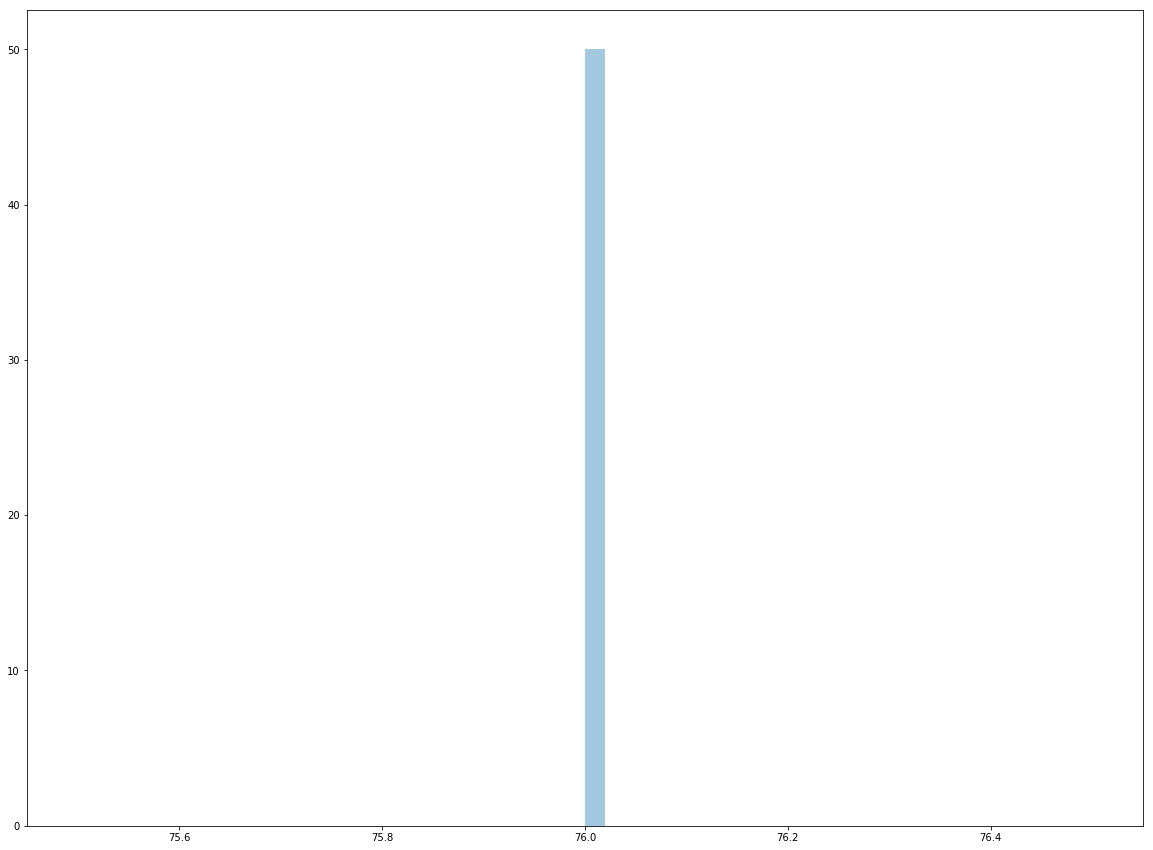

In [14]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
plt.figure(figsize=(20,15))
sns.distplot(modern_lengths)
plt.show()

Looks like we have all modern reads of the same length 76. Let us now extract as many modern reads as we had from the Neanderthal genome:

In [15]:
modern_seqs = []
for j in range(1,2):
    iter = modern.fetch("chr" + str(j))
    for i in iter:
        if len(modern_seqs) == len(neand_seqs):
            break
        else:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                modern_seqs.append(i.get_forward_sequence())
len(modern_seqs)

34956

In [16]:
modern_seqs[0:10]

['TAGCCCTAGCCCTAGCCCTAGCCCTAGCCCTAACCCTAACCCTAACCCTAGCCCTAACCCTACCCCTAACCCTAAC',
 'CCTAACCCTAACCCTAACCCTAACCCTAACCGTAACCCTAAACCCTAAACCCTAACCCTAACCCTAACCCCCCCCC',
 'TGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGCTAAGGTTAAGGGTAAGGGTTAGGGTTAGGGTTAGGGTTAGG',
 'GGTTAGGGTTAGGGTTAGGGTTAGGGTTCGGGTTAGTGTTAGTGGTTGGGTTAGGGTTAGGGTTAGGGTTAGGGAT',
 'AAGGGTTAGGGTTAGGGTTAGGGTTCGGGTTAGGGTTCGGGTTAGGGTTAGGTCTAGGGTTAGGGTTAGGGTTAGG',
 'CTCTTCCGATCTGTTAGGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTT',
 'GGGTCAGGGTCTAGGGTCTAGGGTCTAGGGTCTAGGGTCTAGGGTCTAGGGGTAGGGGTAGGGGTAGGGGTAGGGG',
 'GGCTAGGGCTAGGGCTAGGGCTAGGGTTAGGGTTAGGGTTTAGGGTTGGGTTTAGGGTTGGGGTTGGGGTTGGGGT',
 'TAAATATAACAGGCATATTACTCATGGAGGGTTAGGGTTAGCGTTAGCGTTAGTGTTGGGGTTGGGGTTGGGGTTG',
 'GGTTAGGGTCGGGGTTAGGGTTAGGGTCAGGGGTCAGGGTCAGGGTCAGGGGTCAGGGTCGGGGTCGGGGTCAGGG']

Again as we did it for the ancient sequences, we apply data augmentation, which is the construction of reverse-complement sequences:

In [17]:
from Bio.Seq import Seq
modern_reverse_complement_seqs = [str(Seq(i).reverse_complement()) for i in modern_seqs]
modern_reverse_complement_seqs[0:10]

['GTTAGGGTTAGGGGTAGGGTTAGGGCTAGGGTTAGGGTTAGGGTTAGGGCTAGGGCTAGGGCTAGGGCTAGGGCTA',
 'GGGGGGGGGTTAGGGTTAGGGTTAGGGTTTAGGGTTTAGGGTTACGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG',
 'CCTAACCCTAACCCTAACCCTAACCCTTACCCTTAACCTTAGCCCTAACCCTAACCCTAACCCTAACCCTAACCCA',
 'ATCCCTAACCCTAACCCTAACCCTAACCCAACCACTAACACTAACCCGAACCCTAACCCTAACCCTAACCCTAACC',
 'CCTAACCCTAACCCTAACCCTAGACCTAACCCTAACCCGAACCCTAACCCGAACCCTAACCCTAACCCTAACCCTT',
 'AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACAGATCGGAAGAG',
 'CCCCTACCCCTACCCCTACCCCTACCCCTAGACCCTAGACCCTAGACCCTAGACCCTAGACCCTAGACCCTGACCC',
 'ACCCCAACCCCAACCCCAACCCTAAACCCAACCCTAAACCCTAACCCTAACCCTAGCCCTAGCCCTAGCCCTAGCC',
 'CAACCCCAACCCCAACCCCAACACTAACGCTAACGCTAACCCTAACCCTCCATGAGTAATATGCCTGTTATATTTA',
 'CCCTGACCCCGACCCCGACCCTGACCCCTGACCCTGACCCTGACCCCTGACCCTAACCCTAACCCCGACCCTAACC']

In [18]:
len(modern_reverse_complement_seqs)

34956

In [19]:
modern_seqs_augmented = modern_seqs + modern_reverse_complement_seqs
len(modern_seqs_augmented)

69912

In [20]:
characters = [list(i) for i in modern_seqs_augmented]
set(np.ndarray.flatten(np.array(characters)))

{'A', 'C', 'G', 'T'}

### Prepare Data for Convolutional Neural Network <a class="anchor" id="Prepare Data for Convolutional Neural Network"></a>

Here we will prepare training and test data sets for Convolutional Neural Network (CNN). The training data set will be later split on the fly into "true training" and validation subsets when implementing cross-validation procedure for model fitting. We will start with merging Neanderthal and Modern Human sequences data sets:

In [21]:
sequences = neand_seqs_augmented + modern_seqs_augmented
len(sequences)

139824

Now let us create a list of labels that mark Neanderthal and Modern Human sequences as 1 and 0, respectively:

In [22]:
labels = list(np.ones(len(neand_seqs_augmented))) + list(np.zeros(len(modern_seqs_augmented)))
len(labels)

139824

The next step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). To get each DNA sequence in the form of a matrix, we use one-hot encoding, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AAATCATCAG ... CTCCAAAACT
One hot encoding of Sequence #1:
 [[ 1.  1.  1. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Now we will perform a similar operation with the sequence labels. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features.

In [24]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[ 1.  1.  1. ...,  0.  0.  0.]]
One-hot encoded labels:
 [[ 0.  0.  0. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  0.  0.  0.]]


Finally, let us split the data set into train and test sub-sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training.

In [25]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [26]:
train_features.shape

(104868, 76, 4)

In [27]:
train_labels.shape

(104868, 2)

In [28]:
test_features.shape

(34956, 76, 4)

In [29]:
test_labels.shape

(34956, 2)

Now everything is ready for the classification with Convolutional Neural Network (CNN). Here we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

### Hyperparameter Tuning <a class="anchor" id="Hyperparameter Tuning"></a>

Before starting training the CNN model, we need to figure out a few important hyperparameters such as L1 norm and Dropout regularizations as well as learning rate and batch size. Those hyperparameters will influence the performance of the model a lot, so it is better to pay attention to them. We will start with L1 norm regularization hyperparameter as it will control the overfitting in our model:

Using TensorFlow backend.


Working with L1 = 0.1
Param: 0.100000, Train: 0.500, Test: 0.501
Working with L1 = 0.01
Param: 0.010000, Train: 0.797, Test: 0.793
Working with L1 = 0.001
Param: 0.001000, Train: 0.810, Test: 0.806
Working with L1 = 0.0001
Param: 0.000100, Train: 0.831, Test: 0.820
Working with L1 = 1e-05
Param: 0.000010, Train: 0.836, Test: 0.821
Working with L1 = 1e-06
Param: 0.000001, Train: 0.833, Test: 0.821


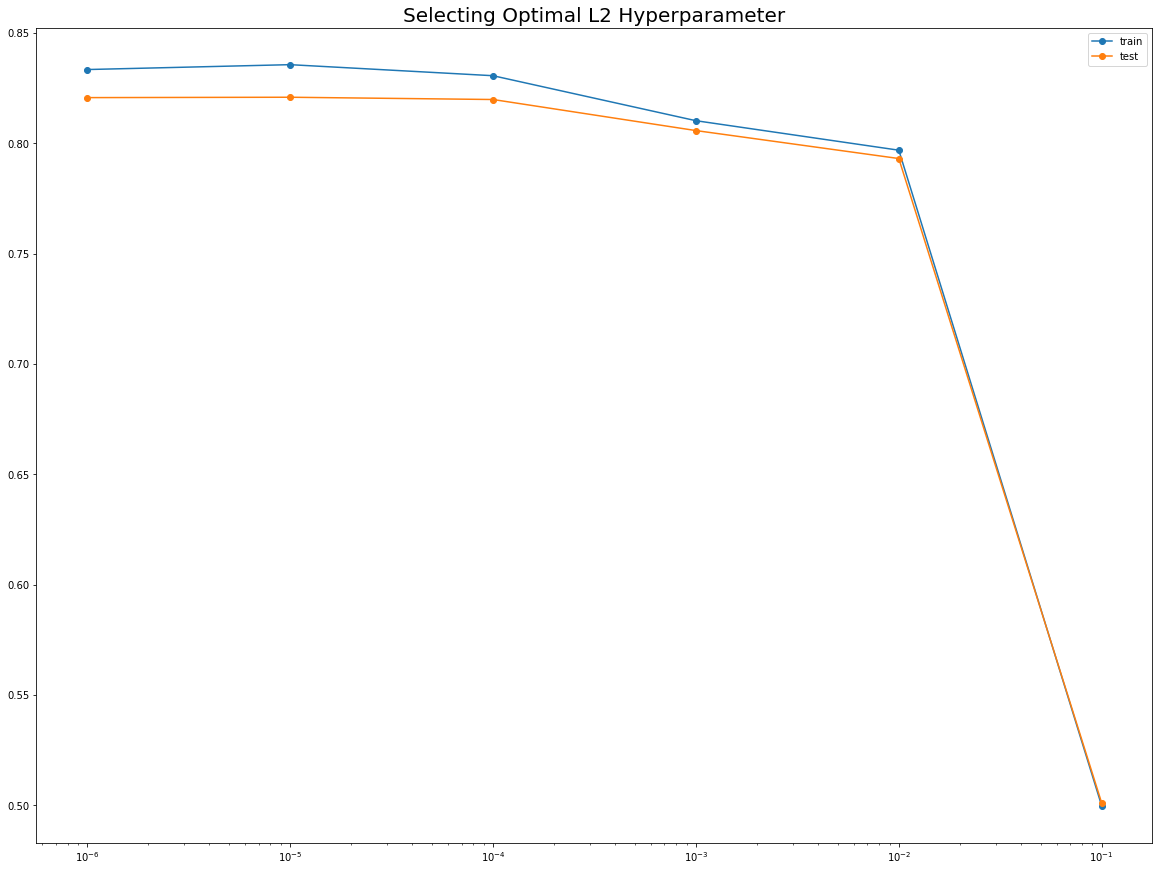

In [30]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with L1 = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu',
                     kernel_regularizer=l1(param)))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu', kernel_regularizer=l1(param)))
    model.add(MaxPooling1D(pool_size = 2))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu', 
                    kernel_regularizer=l1(param)))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = 32, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal L2 Hyperparameter', fontsize = 20)
plt.show()

Working with Dropout = 0.0
Param: 0.000000, Train: 0.849, Test: 0.821
Working with Dropout = 0.2
Param: 0.200000, Train: 0.837, Test: 0.825
Working with Dropout = 0.3
Param: 0.300000, Train: 0.833, Test: 0.824
Working with Dropout = 0.4
Param: 0.400000, Train: 0.827, Test: 0.821
Working with Dropout = 0.5
Param: 0.500000, Train: 0.826, Test: 0.820
Working with Dropout = 0.6
Param: 0.600000, Train: 0.819, Test: 0.815
Working with Dropout = 0.7
Param: 0.700000, Train: 0.817, Test: 0.813


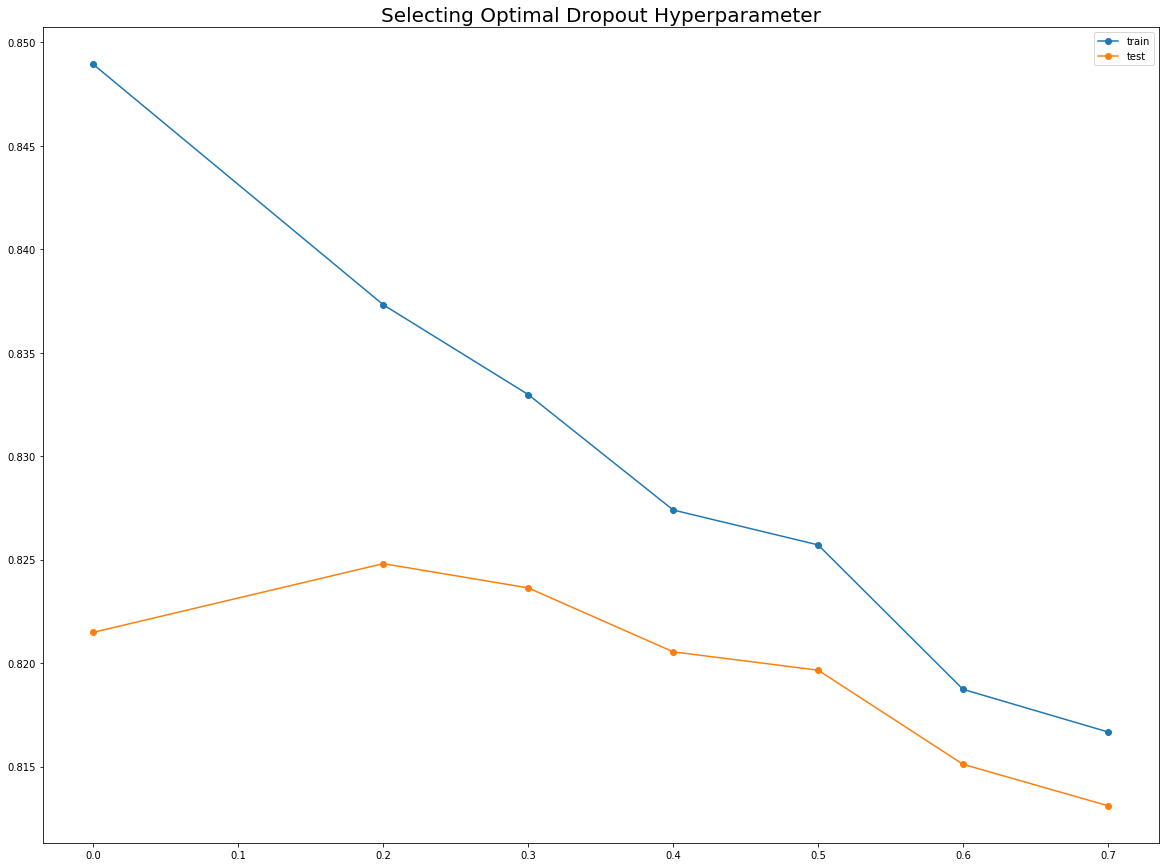

In [31]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

values = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with Dropout = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu'))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(param))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dropout(param))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = 32, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.plot(values, all_train, label='train', marker='o')
plt.plot(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal Dropout Hyperparameter', fontsize = 20)
plt.show()

Working with Batch Size = 8
Param: 8.000000, Train: 0.848, Test: 0.823
Working with Batch Size = 16
Param: 16.000000, Train: 0.847, Test: 0.819
Working with Batch Size = 32
Param: 32.000000, Train: 0.841, Test: 0.819
Working with Batch Size = 64
Param: 64.000000, Train: 0.841, Test: 0.822
Working with Batch Size = 128
Param: 128.000000, Train: 0.840, Test: 0.821
Working with Batch Size = 256
Param: 256.000000, Train: 0.836, Test: 0.819
Working with Batch Size = 512
Param: 512.000000, Train: 0.829, Test: 0.817


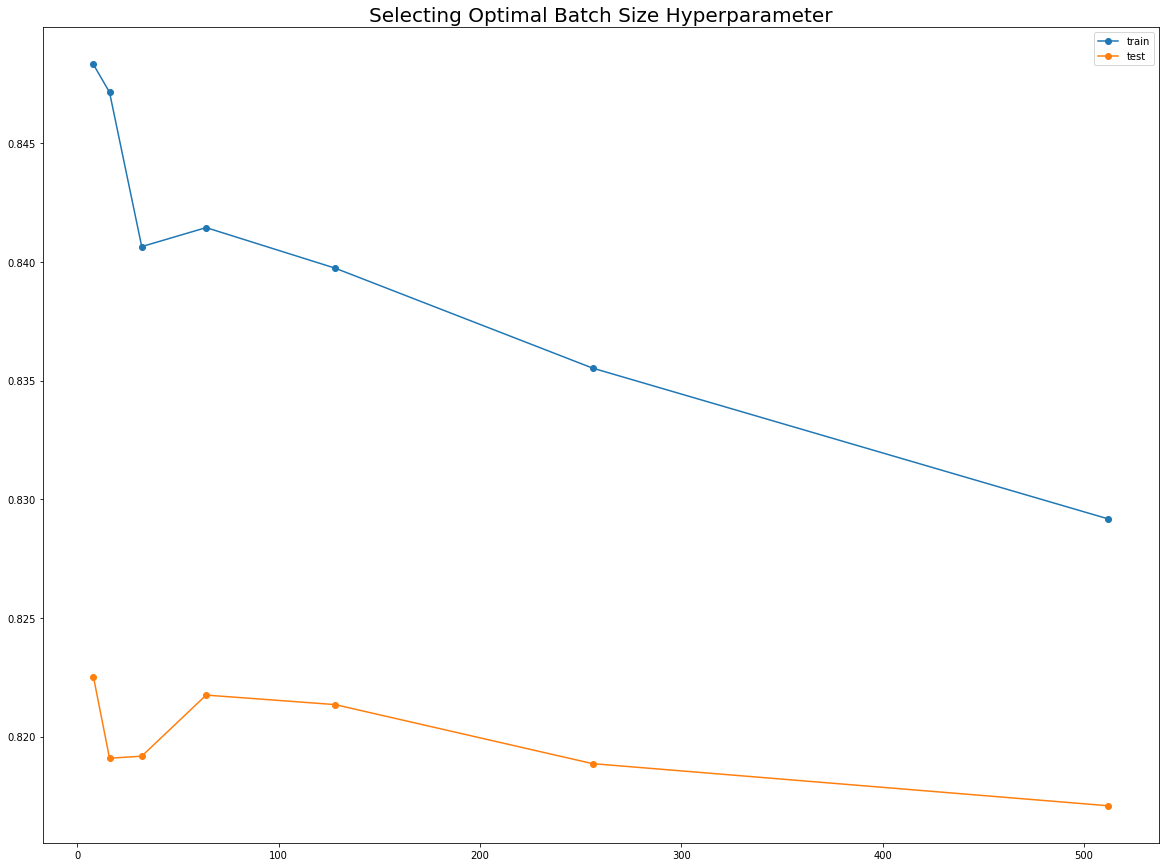

In [32]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

values = [8, 16, 32, 64, 128, 256, 512]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with Batch Size = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu'))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 2))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = param, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.plot(values, all_train, label='train', marker='o')
plt.plot(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal Batch Size Hyperparameter', fontsize = 20)
plt.show()

### Grid Search <a class="anchor" id="Grid Search"></a>

In [ ]:
import sys
import os
os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
import scipy as sp
import random as rn
import sklearn as sk
import pandas as pd

from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

import keras
from keras import metrics, regularizers, optimizers
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,15)

import warnings
warnings.filterwarnings('ignore')

print()
print("Python {}".format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print("Tensor Flow Version: {}".format(tf.__version__))
print("Keras Version: {}".format(keras.__version__))


Python 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas 0.23.4
Numpy 1.13.3
Scikit-Learn 0.19.0

Tensor Flow Version: 1.3.0
Keras Version: 2.0.9


In [ ]:
def create_keras_model(filters = 32, neurons = 16, alpha = 0.001, kernel_size = 5, lrate = 0.01,
                       epochs = 20):
    keras_model = Sequential()
    keras_model.add(Conv1D(filters, kernel_size, padding = 'same', kernel_initializer = 'he_uniform', 
                           input_shape=(train_features.shape[1], 4), activation = 'relu',
                           kernel_regularizer=l2(alpha)))
    keras_model.add(Conv1D(filters, kernel_size, padding = 'same', kernel_initializer = 'he_uniform', 
                           activation = 'relu', kernel_regularizer=l2(alpha)))
    keras_model.add(MaxPooling1D(pool_size = 2))
    
    keras_model.add(Flatten())
    keras_model.add(Dense(neurons, kernel_initializer= 'he_uniform', activation = 'relu',
                          kernel_regularizer=l2(alpha)))
    keras_model.add(Dense(2, activation='softmax'))
    
    epochs = epochs
    lr = lrate
    decay = lr / epochs
    sgd = SGD(lr = lr, momentum = 0.9, decay = decay, nesterov = False)
    keras_model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return keras_model

#Define grid for each hyperparameter
epochs = 20
batch_size = 256
lrate = [0.001, 0.005, 0.01, 0.05]
neurons = [16]
alpha = [0.001]
filters = [32]
kernel_size = [5]

#Wrap the model into KerasClassifier 
keras_model = KerasClassifier(build_fn = create_keras_model, verbose = 0, batch_size = batch_size, 
                              epochs = epochs)

#Run grid search cross-validation procedure
import time
start_time = time.time()
param_grid = dict(neurons=neurons, filters=filters, kernel_size=kernel_size, alpha=alpha, lrate=lrate)
grid = GridSearchCV(estimator = keras_model, param_grid = param_grid, n_jobs = 1, cv = 2)
grid_result = grid.fit(train_features, train_labels)

#Collect results and display best combination of hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
stop_time = time.time()
print()
print("It took {0} seconds for the program to run".format(stop_time - start_time))

### Run Shallow Convolutional Neural Network <a class="anchor" id="Run Shallow Convolutional Neural Network"></a>

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of an ancient site on a sequence). We will start with defining Convolutional Neural Network (CNN) model and summarize the fitting parameters of the model. 

In [66]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2, l1

model = Sequential()

model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 input_shape=(train_features.shape[1], 4), activation = 'relu',
                 kernel_regularizer=l1(0.001)))
model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 activation = 'relu',
                 kernel_regularizer=l1(0.001)))
model.add(MaxPooling1D(pool_size = 2))


model.add(Flatten())
model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu', 
                kernel_regularizer=l1(0.001)))
model.add(Dense(2, activation='softmax'))

epochs = 1000
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 76, 32)            672       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 76, 32)            5152      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                19472     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 34        
Total params: 25,330
Trainable params: 25,330
Non-trainable params: 0
_________________________________________________________________


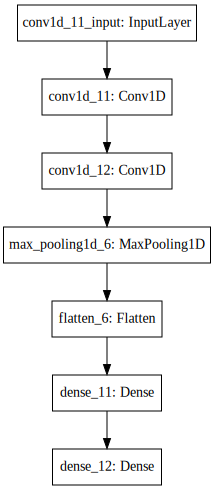

In [67]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

In [68]:
history = model.fit(train_features, train_labels, epochs = epochs, verbose = 1, validation_split = 0.25,
                   batch_size = 256, shuffle = True)

Train on 78651 samples, validate on 26217 samples
Epoch 1/1000
78651/78651 [==============================] - 22s 280us/step - loss: 1.8565 - binary_accuracy: 0.7369 - val_loss: 1.7642 - val_binary_accuracy: 0.7779
Epoch 2/1000
78651/78651 [==============================] - 20s 255us/step - loss: 1.7174 - binary_accuracy: 0.7860 - val_loss: 1.6740 - val_binary_accuracy: 0.7881
Epoch 3/1000
78651/78651 [==============================] - 23s 289us/step - loss: 1.6316 - binary_accuracy: 0.7937 - val_loss: 1.5957 - val_binary_accuracy: 0.7963
Epoch 4/1000
78651/78651 [==============================] - 22s 285us/step - loss: 1.5543 - binary_accuracy: 0.7983 - val_loss: 1.5213 - val_binary_accuracy: 0.8006
Epoch 5/1000
78651/78651 [==============================] - 21s 265us/step - loss: 1.4828 - binary_accuracy: 0.8020 - val_loss: 1.4524 - val_binary_accuracy: 0.8011
Epoch 6/1000
78651/78651 [==============================] - 24s 302us/step - loss: 1.4157 - binary_accuracy: 0.8039 - val_los

78651/78651 [==============================] - 24s 304us/step - loss: 0.5766 - binary_accuracy: 0.8149 - val_loss: 0.5769 - val_binary_accuracy: 0.8115
Epoch 51/1000
78651/78651 [==============================] - 20s 248us/step - loss: 0.5723 - binary_accuracy: 0.8150 - val_loss: 0.5736 - val_binary_accuracy: 0.8149
Epoch 52/1000
78651/78651 [==============================] - 23s 292us/step - loss: 0.5680 - binary_accuracy: 0.8143 - val_loss: 0.5684 - val_binary_accuracy: 0.8139
Epoch 53/1000
78651/78651 [==============================] - 21s 266us/step - loss: 0.5637 - binary_accuracy: 0.8156 - val_loss: 0.5643 - val_binary_accuracy: 0.8138
Epoch 54/1000
78651/78651 [==============================] - 21s 261us/step - loss: 0.5601 - binary_accuracy: 0.8150 - val_loss: 0.5662 - val_binary_accuracy: 0.8059
Epoch 55/1000
78651/78651 [==============================] - 20s 251us/step - loss: 0.5562 - binary_accuracy: 0.8155 - val_loss: 0.5636 - val_binary_accuracy: 0.8055
Epoch 56/1000
7865

78651/78651 [==============================] - 19s 246us/step - loss: 0.4860 - binary_accuracy: 0.8158 - val_loss: 0.4881 - val_binary_accuracy: 0.8155
Epoch 100/1000
78651/78651 [==============================] - 21s 264us/step - loss: 0.4852 - binary_accuracy: 0.8166 - val_loss: 0.4871 - val_binary_accuracy: 0.8148
Epoch 101/1000
78651/78651 [==============================] - 23s 291us/step - loss: 0.4845 - binary_accuracy: 0.8164 - val_loss: 0.4879 - val_binary_accuracy: 0.8144
Epoch 102/1000
78651/78651 [==============================] - 21s 262us/step - loss: 0.4835 - binary_accuracy: 0.8157 - val_loss: 0.4864 - val_binary_accuracy: 0.8134
Epoch 103/1000
78651/78651 [==============================] - 23s 296us/step - loss: 0.4821 - binary_accuracy: 0.8162 - val_loss: 0.4862 - val_binary_accuracy: 0.8131
Epoch 104/1000
78651/78651 [==============================] - 23s 298us/step - loss: 0.4818 - binary_accuracy: 0.8163 - val_loss: 0.4842 - val_binary_accuracy: 0.8150
Epoch 105/100

78651/78651 [==============================] - 20s 258us/step - loss: 0.4515 - binary_accuracy: 0.8178 - val_loss: 0.4544 - val_binary_accuracy: 0.8147
Epoch 149/1000
78651/78651 [==============================] - 19s 247us/step - loss: 0.4518 - binary_accuracy: 0.8178 - val_loss: 0.4532 - val_binary_accuracy: 0.8156
Epoch 150/1000
78651/78651 [==============================] - 20s 257us/step - loss: 0.4508 - binary_accuracy: 0.8178 - val_loss: 0.4550 - val_binary_accuracy: 0.8134
Epoch 151/1000
78651/78651 [==============================] - 22s 276us/step - loss: 0.4504 - binary_accuracy: 0.8178 - val_loss: 0.4520 - val_binary_accuracy: 0.8159
Epoch 152/1000
78651/78651 [==============================] - 22s 275us/step - loss: 0.4504 - binary_accuracy: 0.8178 - val_loss: 0.4577 - val_binary_accuracy: 0.8144
Epoch 153/1000
78651/78651 [==============================] - 20s 254us/step - loss: 0.4503 - binary_accuracy: 0.8173 - val_loss: 0.4597 - val_binary_accuracy: 0.8134
Epoch 154/100

78651/78651 [==============================] - 23s 296us/step - loss: 0.4380 - binary_accuracy: 0.8182 - val_loss: 0.4397 - val_binary_accuracy: 0.8152
Epoch 198/1000
78651/78651 [==============================] - 20s 261us/step - loss: 0.4378 - binary_accuracy: 0.8176 - val_loss: 0.4399 - val_binary_accuracy: 0.8154
Epoch 199/1000
78651/78651 [==============================] - 20s 253us/step - loss: 0.4381 - binary_accuracy: 0.8177 - val_loss: 0.4398 - val_binary_accuracy: 0.8154
Epoch 200/1000
78651/78651 [==============================] - 20s 251us/step - loss: 0.4380 - binary_accuracy: 0.8180 - val_loss: 0.4389 - val_binary_accuracy: 0.8147
Epoch 201/1000
78651/78651 [==============================] - 24s 303us/step - loss: 0.4378 - binary_accuracy: 0.8174 - val_loss: 0.4390 - val_binary_accuracy: 0.8150
Epoch 202/1000
78651/78651 [==============================] - 20s 250us/step - loss: 0.4374 - binary_accuracy: 0.8174 - val_loss: 0.4433 - val_binary_accuracy: 0.8126
Epoch 203/100

KeyboardInterrupt: 

Let us visualize the training and cross-validated model loss and accuracy:

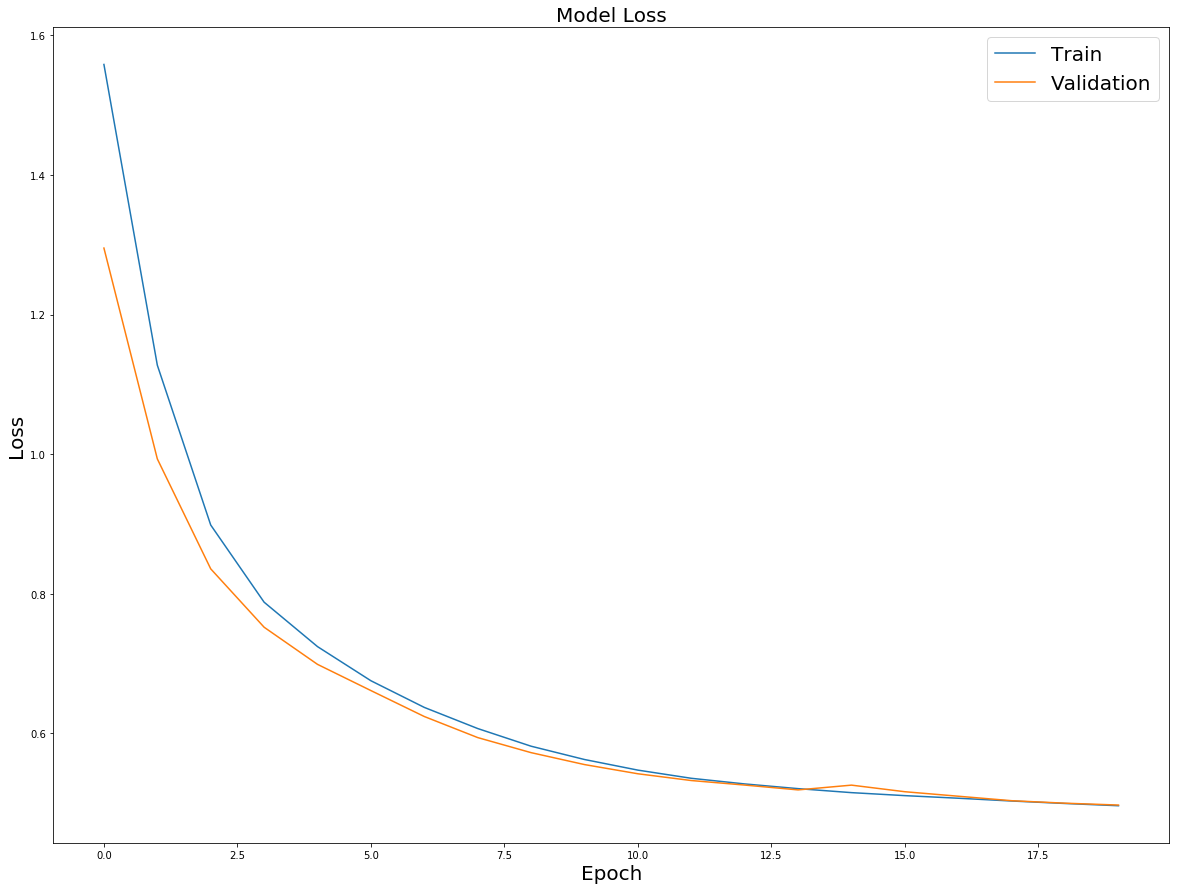

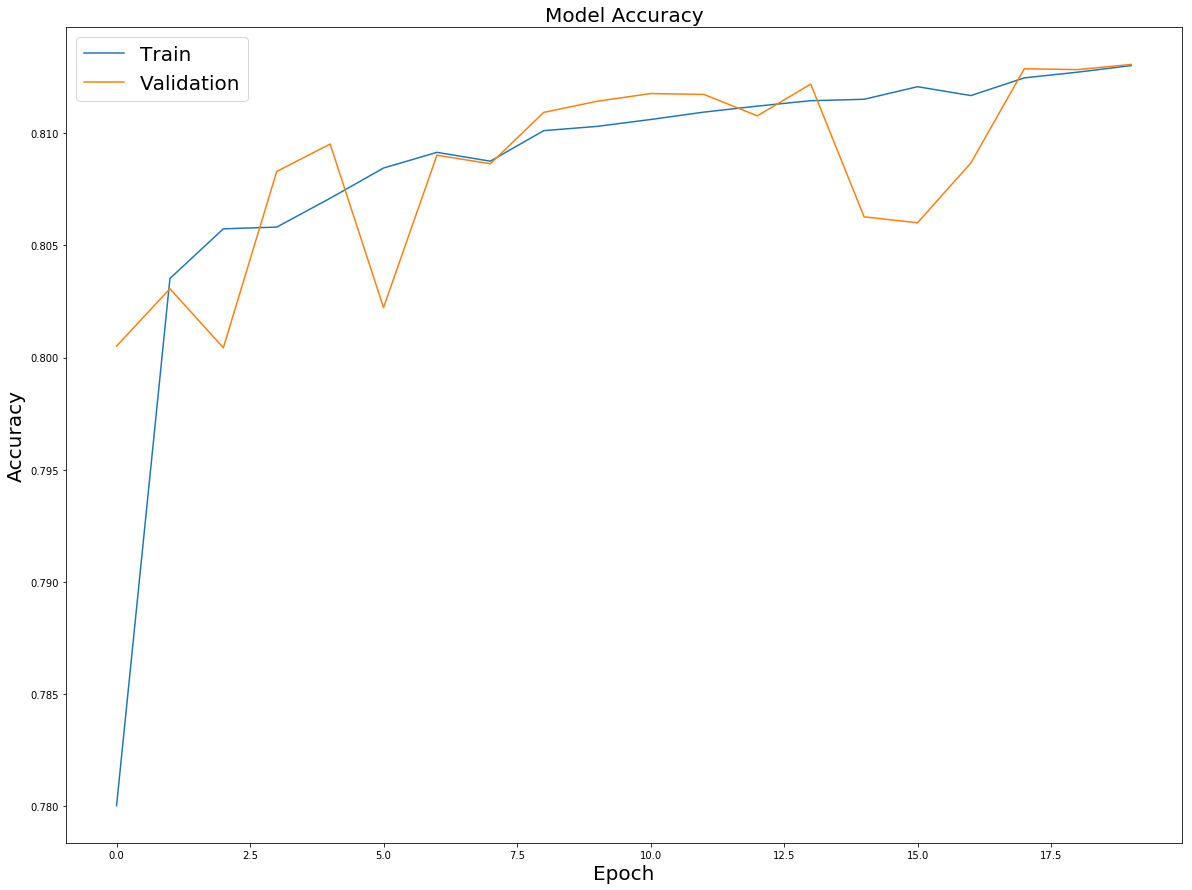

In [65]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Now we are going to save the trained model and use it later for making predictions on independent samples like the ones from Mezmayskaya Neanderthals which are known to have a very low level of modern human contamination:

In [ ]:
model.save('DeepLearningAncientDNA_ShallowModel.h5')

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [ ]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Therefore the final accuracy of classification is around 84%, it is not fantastic but we can do it much better later. The results so far should allow you to conclude that the neural network is quite effective in learning to distinguish ancient and non-ancient sequences. But can we understand why the neural network classifies a training point in the way that it does? Now it is time for model interpretation. 


### Interpret Results of Convolutional Neural Network <a class="anchor" id="Interpret Results of Convolutional Neural Network"></a>

To interpret the results of the CNN, we can compute a simple **saliency map**, which is the gradient of the model's prediction with respect to each individual nucleotide. In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides are most informative for descrimination between ancient and modern sequences.

In [ ]:
import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

Here we will take a random ancient read and show that the ends of the read are responsible for read classification as the bases at the ends of the read demonstrate the highst importartance for the prediction:

In [ ]:
sequence_index = 12
K.set_learning_phase(1) #set learning phase
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(0,6)]
[barlist[j].set_color('C1') for j in range(71,76)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the ancient sequences'
          ' (orange indicates the informative bases in motif)');
plt.show()

We can see that the nucleotides at the ends of the reads tend to be more important for the prediction, which agrees with the common knowledge that the ends of ancient reads tend to be deaminated.

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different hyper-parameters, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the ancient motifs.

### Predict Ancient Status <a class="anchor" id="Predict Ancient Status"></a>

Now we can use the trained CNN for generating predictions of ancient status for each read in a given sample. Let us use Mezmayskaya 1 Neanderthal sample which is known to have a very low modern DNA comtamination and check what would the percentage of contaminant reads. For this purpose, we again need to select reads of leangth 76 since our CNN was trained only on those reads:

In [ ]:
import os
import pysam
import numpy as np
os.chdir('/home/nikolay/WABI/Misc/AncientDNA/')
mez = pysam.AlignmentFile("Mez1.bam", "rb")

In [ ]:
mez_seqs = []
for j in range(1,23):
    iter = mez.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                mez_seqs.append(i.get_forward_sequence())
len(mez_seqs)

In [ ]:
mez_seqs[0:10]

Again we need to one-hot encode the Mezmayskaya 1 Neanderthal sequences:

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
mez_input_features = []

for sequence in mez_seqs:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  mez_input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
mez_input_features = np.stack(mez_input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',mez_seqs[0][:10],'...',mez_seqs[0][-10:])
print('One hot encoding of Sequence #1:\n',mez_input_features[0].T)

Now it is time to predict class, i.e. "ancient" ot "modern contaminant" for each read:

In [ ]:
from keras.models import load_model
mez_model = load_model('DeepLearningAncientDNA_ShallowModel.h5')
class_pred = mez_model.predict_classes(mez_input_features)

In [ ]:
sum(class_pred == 1)/len(mez_seqs)

Thus we conclude that the majority of the reads, approximately **75%**, are indeed ancient since most of the time we predict status 1 (ancient) for the reads, we predict that Mezmayskaya 1 Neanderthal sample contains approximately 25% of modern DNA contamination. Let us compare this percentage of ancient reads with the corresponding number from modern human sample: 

In [ ]:
import os
import pysam
import numpy as np
os.chdir('/home/nikolay/WABI/Misc/AncientDNA/')
han = pysam.AlignmentFile("Han.bam", "rb")

In [ ]:
han_seqs = []
for j in range(1,2):
    iter = han.fetch('chr' + str(j), 1, 1000000)
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                han_seqs.append(i.get_forward_sequence())
len(han_seqs)

In [ ]:
han_seqs[0:10]

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 0 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
han_input_features = []

for sequence in han_seqs:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  han_input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
han_input_features = np.stack(han_input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',han_seqs[0][:10],'...',han_seqs[0][-10:])
print('One hot encoding of Sequence #1:\n',han_input_features[0].T)

In [ ]:
from keras.models import load_model
han_model = load_model('DeepLearningAncientDNA_ShallowModel.h5')
class_pred = han_model.predict_classes(han_input_features)

In [ ]:
sum(class_pred == 1)/len(han_seqs)

Thus, the modern human sample has approximately **22% of ancient reads**, or more correctly "ancient looking" reads. Ideally, if our shallow CNN was perfect, we should obtain close to 100% of reads in the Mezmayskaya 1 Neanderthal sample to be ancient and close to 0% of reads in the modern Han human sample to be ancient. However, our shallow CNN still does a pretty good job since it is a simple "ancient / non-ancient" decision maker, which in principle can be an alternative to **mapDamage** deamination pattern analysis.

Since our CNN provides a per-read ancient status assignment, let us now separate the 75% of "ancient" reads (or what was predicted by CNN to be "ancient") in the Mezmayskaya 1 Neanderthal sample from the 25% of "modern contaminant" reads and run mapDamage on those two bam-files. The hypothesis is that we should see a much stronger deamination pattern in the 75% "ancient reads" and a much weaker signal in the 25% "modern contaminant reads".

In [ ]:
from keras.models import load_model
mez_model = load_model('DeepLearningAncientDNA_ShallowModel.h5')
class_pred = mez_model.predict_classes(mez_input_features)

In [ ]:
mez = pysam.AlignmentFile("Mez1.bam", "rb")
mez_76 = pysam.AlignmentFile("Mez1_76.bam", "wb", template=mez)

for j in range(1,23):
    iter = mez.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A')>0 and s.count('C')>0 and s.count('G')>0 and s.count('T')>0 and 'N' not in s:
                mez_76.write(i)
mez.close()
mez_76.close()

In [ ]:
import pysam
mez = pysam.AlignmentFile("Mez1_76.bam", "rb")
ancient_mez = pysam.AlignmentFile("Mez1_Ancient.bam", "wb", template=mez)
modern_mez = pysam.AlignmentFile("Mez1_Modern.bam", "wb", template=mez)

for read, k in zip(mez.fetch(), range(class_pred.shape[0])):
    if class_pred[k]==1:
        ancient_mez.write(read)
    else:
        modern_mez.write(read)
mez.close()
ancient_mez.close()
modern_mez.close()

In [ ]:
#mapDamage -i Mez1_Ancient.bam -r hg18.fa
#mapDamage -i Mez1_Modern.bam -r hg18.fa

The deamination profiles for "ancient" and "modern" reads look very similar meaning that the 20% of reads predicted to be modern contaminants by the CNN model are most likely ancient and we need to improve oi CNN model in order to get close to 100% of reads to be predicted to be ancient in the Mezmayskaya 1 Neanderthal sample.

### Run Deep Convolutional Neural Network <a class="anchor" id="Run Deep Convolutional Neural Network"></a>

Here we will configure a 3-block VGG-like Deep Convolutional Neural Network. We will use Batch Normalization and Dropour regularization in order to improve performance of the model:

In [ ]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l1

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform', 
                 input_shape=(train_features.shape[1], 4)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

epochs = 50
lrate = 0.01
#decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
sgd = SGD(lr = lrate, momentum = 0.9)
#model.load_weights("weights.best.hdf5")
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

In [ ]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
rlrp = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 5, verbose = 1, min_lr = 0.001)

history = model.fit(train_features, train_labels, callbacks=[rlrp, checkpoint], 
                    epochs=epochs, verbose=1, validation_split=0.25, batch_size=256, shuffle=True)

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

It looks like we do not have major problems with overfitting thanks to Dropout and Batch Normalization, i.e.  training and validation loss and accuracy curves follow each other very well. However, bad news is that 50 epochs (which took approximately 10 hours on my laptop) was not enough to achieve high enough accuracy and we probably have to train for much longer in order to see a considerable progress. Nevertheless the slopes of the curves look promising meaning that the problem is learnable and we might get better results in the future. Let us now save the Deep Model and continue with evaluation of the model:

In [ ]:
model.save('DeepLearningAncientDNA_DeepModel.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [ ]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

So the accuracy is around 84% meaning that the Deep Model did not outperform substantially the Shallow Model. However, while the Shallow MOdel was clearly overfitting and was unlikely to achieve higher accuracies with more training, the Deep Model trend looks more promising and we should train for longer time.